In [1]:
!pip install transformers
!pip install sentencepiece
!pip3 install mvlearn

from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 11.4 MB/s 
     |████████████████████████████████| 596 kB 46.1 MB/s 
     |████████████████████████████████| 6.6 MB 32.7 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 11.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 25.8 MB/s 
     |████████████████████████████████| 38.1 MB 76.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
E

In [2]:
import os
os.chdir('drive/MyDrive/William_2022/DATASETS/trans_encoder_2')

import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from model_new import Transformer, Transformer2, Encoder
from config import *
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm import tqdm
from optim_new import ScheduledOptim
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from CCA import DeepCCA, cca_loss
from scipy.stats import wasserstein_distance
from mvlearn.embed import DCCA
from mvlearn.datasets import make_gaussian_mixture
from mvlearn.plotting import crossviews_plot
from dataset_new import Fusion

In [3]:
text_chkpt = torch.load('baselines/text/0angry2_trans_baseline_onlytext.chkpt', map_location = torch.device('cpu'))
eeg_chkpt = torch.load('baselines/eeg/0angry2_trans_baseline_onlyeeg.chkpt', map_location = torch.device('cpu'))

fusion_chkpt = torch.load('baselines/text_eeg_fusion/0angry2_trans_baseline_fusion.chkpt', map_location = torch.device('cpu'))
text_eeg_CE_chkpt = torch.load('baselines/text_eeg_CE/0angry2_trans_baseline_eeg_plus_textCE.chkpt', map_location = torch.device('cpu'))

Simultaneous_text_chkpt = torch.load('baselines/Simultaneous_text_eeg/0angry2_trans_baseline_simul_text.chkpt', map_location = torch.device('cpu'))
Simultaneous_eeg_chkpt = torch.load('baselines/Simultaneous_text_eeg/0angry2_trans_baseline_simul_eeg.chkpt', map_location = torch.device('cpu'))

fusion_wd_chkpt = torch.load('baselines/fusion_wd/0angry2_trans_baseline_fusion_wd.chkpt', map_location = torch.device('cpu'))
fusion_cossim_chkpt = torch.load('baselines/fusion_cossim/0angry2_trans_baseline_fusion_cossim.chkpt', map_location = torch.device('cpu'))

dcca_fusion_chkpt = torch.load('baselines/DCCA_fusion/0angry2_trans_baseline_DCCA_fusion.chkpt', map_location = torch.device('cpu'))
dcca_CE_chkpt = torch.load('baselines/DCCA_CE/0angry2_trans_baseline_DCCA_CE.chkpt', map_location = torch.device('cpu'))

dcca_chkpt = torch.load('baselines/DCCA/0angry2_trans_baseline_DCCA_only.chkpt', map_location = torch.device('cpu'))

df_train1 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred_train.txt')
df_train1_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label_train.txt')

df_val1 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred_val.txt')
df_val1_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label_val.txt')

df_test1 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred_test.txt')
df_test1_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label_test.txt')

df_train2 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred2_train.txt')
df_train2_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label2_train.txt')

df_val2 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred2_val.txt')
df_val2_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label2_val.txt')

df_test2 = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_pred2_test.txt')
df_test2_lbl = np.loadtxt('arousal2_trans_baseline_DCCA_only_all_label2_test.txt')

In [30]:
n_samples = 2000
means = [[0, 1], [0, -1]]
covariances = [np.eye(2), np.eye(2)]
Xs, y, latent = make_gaussian_mixture(
      n_samples, means, covariances, transform='poly', random_state=42,
      shuffle=True, shuffle_random_state=42, return_latents=True)

In [36]:
Xs

[array([[ -0.14905961,  -0.34112716,  -0.01784308],
        [ -0.27590635,  -0.38919657,  -0.19475839],
        [ -0.33426243,  -0.33572954,  -0.25930887],
        ...,
        [ -1.74651372, -13.17707539, -11.67911148],
        [ -4.68469381, -12.22555733,  -7.22608852],
        [  0.3864058 ,  -7.90556479, -10.20604801]]),
 array([[ -0.06861365,  -0.63905561,   0.09046419],
        [ -0.20051363,  -0.97999352,   0.20022164],
        [  0.14512071,   1.26026809,  -0.54900885],
        ...,
        [-22.552145  ,   1.41402447,  22.3030262 ],
        [-15.79481125,  -1.20822489,  23.42234039],
        [-17.07021523,  -0.28945771,  25.60379028]])]

In [32]:
Xs = []
Xs.append(df_train1)
Xs.append(df_train2)

In [39]:
Xs_test = []
Xs_test.append(df_test1)
Xs_test.append(df_test2)

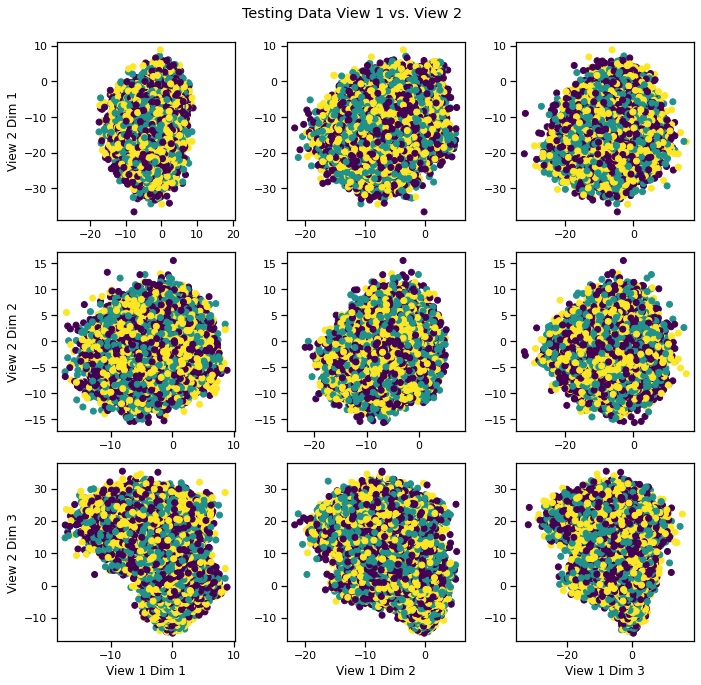

In [38]:
crossviews_plot(Xs, labels=df_train1_lbl,
                title='Testing Data View 1 vs. View 2 ',
                equal_axes=True)

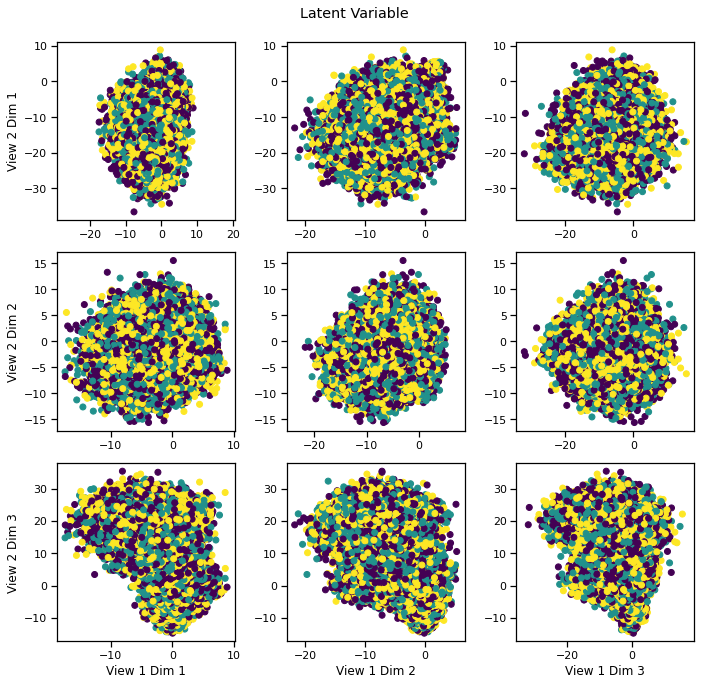

In [6]:
crossviews_plot([df_train1, df_train2], labels=df_train1_lbl,
                title='Latent Variable', equal_axes=True)

In [56]:
features1 = Xs[0].shape[1]  # Feature sizes
features2 = Xs[1].shape[1]
layers1 = [256, 256, 3]  # nodes in each hidden layer and the output size
layers2 = [256, 256, 3]

dcca = DCCA(input_size1=features1, input_size2=features2, n_components=3,
            layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=10)
dcca.fit(Xs)
Xs_transformed = dcca.transform(Xs_test)

/usr/local/lib/python3.7/dist-packages/mvlearn/embed/dcca.py:687: Warning: Loss did not converge before 10 epochs. Consider increasing epoch_num to train for longer.
  warnings.warn(message, Warning)


In [50]:
y_test = []
y_test.append(df_test1_lbl)
y_test.append(df_test2_lbl)

In [49]:
len(Xs_transformed[0])

412

In [52]:
len(y_test[0])

412

In [54]:
Xs_transformed

[array([[0.89035405, 0.66555967, 1.72402533, 3.31038972],
        [0.95507855, 0.56595473, 1.71937146, 3.50473792],
        [0.69355933, 0.9524784 , 1.42827581, 2.19598715],
        ...,
        [0.93337924, 0.64179461, 1.84516816, 3.51213579],
        [0.87805226, 0.69359228, 1.60571621, 3.05612618],
        [0.9789756 , 0.62716908, 1.67584688, 3.15602443]]),
 array([[ 0.44440094,  0.61153171,  0.27582816,  1.91409966],
        [ 0.24341821,  0.58887895,  0.21640296,  1.957867  ],
        [ 0.56972405,  1.64063929,  3.50771607,  4.06834726],
        ...,
        [ 0.53901961,  1.42262299,  2.89404399,  5.89783331],
        [ 0.5007562 ,  1.51835965,  3.03069609,  5.79084426],
        [ 1.24527353,  0.85863912,  1.99020295, -0.35249502]])]

ValueError: ignored

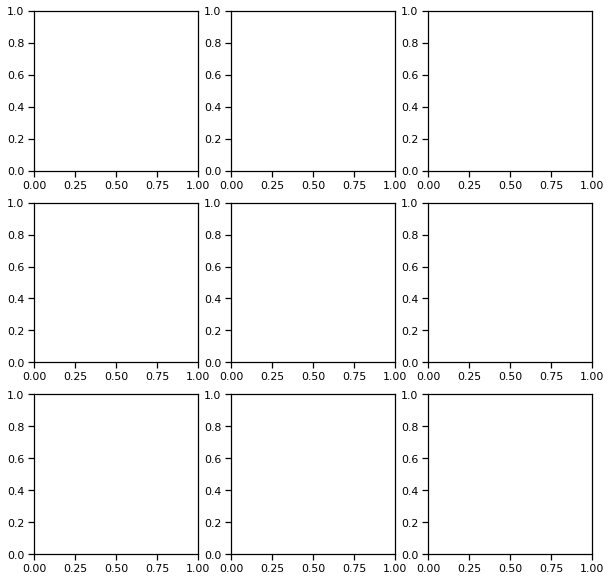

In [57]:
crossviews_plot(Xs_transformed, labels=y_test,
                title='Transformed Testing Data View 1 vs. View 2 ',
                equal_axes=True)

In [ ]:
batch_size = 8
d_model = 16

num_layers = 2
num_heads = 4
class_num = 2
d_inner = 32
dropout = 0.1
warm_steps = 4000
fea_num = 7
epoch = 100
PAD = 0
KS = 3

Fea_PLUS = 2
# SIG_LEN = 48
SIG_LEN = 32
SIG_LEN2 = 48
SIG_LEN3 = 80
MAX_LEN = 32
PRE_TRAINED_MODEL_NAME = 'j-hartmann/emotion-english-distilroberta-base'
emotion = 'angry2_trans'
csv = 'df.csv'

# eeg = [emotion, 'delta0', 'lowAlpha0', 'highAlpha0','lowBeta0','highBeta0', 'lowGamma0', 'middleGamma0', 'theta0',
#          'delta1', 'lowAlpha1', 'highAlpha1', 'lowBeta1', 'highBeta1', 'lowGamma1', 'middleGamma1', 'theta1',
#          'delta2', 'lowAlpha2', 'highAlpha2', 'lowBeta2', 'highBeta2', 'lowGamma2', 'middleGamma2', 'theta2',
#          'delta3', 'lowAlpha3', 'highAlpha3', 'lowBeta3', 'highBeta3', 'lowGamma3', 'middleGamma3', 'theta3',
#          'delta4', 'lowAlpha4', 'highAlpha4', 'lowBeta4', 'highBeta4', 'lowGamma4', 'middleGamma4', 'theta4',
#          'delta5', 'lowAlpha5', 'highAlpha5', 'lowBeta5', 'highBeta5', 'lowGamma5', 'middleGamma5', 'theta5']

eeg = [emotion, 'delta0_2', 'lowAlpha0_2', 'highAlpha0_2','lowBeta0_2','highBeta0_2', 'lowGamma0_2', 'middleGamma0_2', 'theta0_2',
         'delta1_2', 'lowAlpha1_2', 'highAlpha1_2', 'lowBeta1_2', 'highBeta1_2', 'lowGamma1_2', 'middleGamma1_2', 'theta1_2',
         'delta2_2', 'lowAlpha2_2', 'highAlpha2_2', 'lowBeta2_2', 'highBeta2_2', 'lowGamma2_2', 'middleGamma2_2', 'theta2_2',
         'delta3_2', 'lowAlpha3_2', 'highAlpha3_2', 'lowBeta3_2', 'highBeta3_2', 'lowGamma3_2', 'middleGamma3_2', 'theta3_2',
         'delta4_2', 'lowAlpha4_2', 'highAlpha4_2', 'lowBeta4_2', 'highBeta4_2', 'lowGamma4_2', 'middleGamma4_2', 'theta4_2',
         'delta5_2', 'lowAlpha5_2', 'highAlpha5_2', 'lowBeta5_2', 'highBeta5_2', 'lowGamma5_2', 'middleGamma5_2', 'theta5_2']

torchload = 'baselines/text/0angry2_trans_baseline_onlytext.chkpt'
torchload2 = 'baselines/eeg/0angry2_trans_baseline_onlyeeg.chkpt'

In [ ]:
if torch.cuda.is_available():
            device = torch.device('cuda')
else:
  device = torch.device('cpu')


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

class EEGDataset(Dataset):
    def __init__(self, signal, label):

        self._signal = torch.FloatTensor(signal)
        self._label = torch.LongTensor(label)


    @property
    def n_insts(self):
        ''' Property for dataset size '''
        return len(self._label)

    @property
    def sig_len(self):
        return self._signal.shape[1]

    def __len__(self):
        return self.n_insts

    def __getitem__(self, idx):
        return self._signal[idx], self._label[idx]

class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  @property
  def n_insts(self):
    return len(self.labels)

  @property
  def text_len(self):
    return 32

  def __len__(self):
    return self.n_insts

  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length = True,
      return_attention_mask=True
      #return_tensors='pt',
    )
    return torch.FloatTensor(encoding['input_ids']).flatten(), torch.tensor(label, dtype=torch.long)



In [ ]:
# --- Preprocess
df = pd.read_csv('df.csv')

X = df.drop([emotion], axis = 1)
y= df[[emotion]]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2, test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state= 2, test_size = 0.5)
df_test = pd.concat([X_test, y_test], axis = 1)
df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)

df_train_text = df_train[[emotion, 'new_words']]
df_train_eeg = df_train[eeg]

df_val_text = df_val[[emotion, 'new_words']]
df_val_eeg = df_val[eeg]

df_test_text = df_test[[emotion, 'new_words']]
df_test_eeg = df_test[eeg]

# --- Save CSV
df_train_text.to_csv('df_train_text.csv', header = None, index = False, index_label = False)
df_train_eeg.to_csv('df_train_eeg.csv', header = None, index = False, index_label = False)

df_val_text.to_csv('df_val_text.csv', header = None, index = False, index_label = False)
df_val_eeg.to_csv('df_val_eeg.csv', header = None, index = False, index_label=False)


df_test_text.to_csv('df_test_text.csv', header = None, index = False, index_label = False)
df_test_eeg.to_csv('df_test_eeg.csv', header = None, index = False, index_label=False)

# --- Load CSV
df_train_text = pd.read_csv('df_train_text.csv', header = None).values
df_train_eeg = pd.read_csv('df_train_eeg.csv', header = None).values

df_val_text= pd.read_csv('df_val_text.csv', header = None).values
df_val_eeg = pd.read_csv('df_val_eeg.csv', header = None).values

df_test_text= pd.read_csv('df_test_text.csv', header = None).values
df_test_eeg = pd.read_csv('df_test_eeg.csv', header = None).values

# --- RandomOverSampling
# Text

X_text_train = df_train_text[:, 1:]
y_text_train = df_train_text[:, 0]
y_text_train = y_text_train.astype('int')

ros = RandomOverSampler(random_state=2)
X_resampled_text, y_resampled_text = ros.fit_resample(X_text_train, y_text_train)

# print(df_)
# EEG

X_eeg_train = df_train_eeg[:, 1:]
y_eeg_train = df_train_eeg[:, 0]

ros = RandomOverSampler(random_state=2)
X_resampled_eeg, y_resampled_eeg = ros.fit_resample(X_eeg_train, y_eeg_train)



# --- Text
train_text = TextDataset(
    texts = X_resampled_text,
    labels = y_resampled_text,
    tokenizer = tokenizer,
    max_len = MAX_LEN
)
val_text = TextDataset(
    texts = df_val_text[:, 1:],
    labels = df_val_text[:, 0],
    tokenizer = tokenizer,
    max_len = MAX_LEN
)

test_text = TextDataset(
  texts = df_test_text[:, 1:],
  labels = df_test_text[:, 0],
  tokenizer = tokenizer,
  max_len = MAX_LEN

)
train_loader_text = DataLoader(dataset=train_text,
                          batch_size=batch_size,
                          num_workers=2
                          )
valid_loader_text = DataLoader(dataset=val_text,
                          batch_size=batch_size,
                          num_workers=2
                          )
test_loader_text = DataLoader(dataset=test_text,
                          batch_size=batch_size,
                          num_workers=2
                          )
# --- EEG
train_eeg = EEGDataset(
    signal = X_resampled_eeg,
    label = y_resampled_eeg
)

val_eeg = EEGDataset(
    signal = df_val_eeg[:, 1:],
    label = df_val_eeg[:, 0]
)

test_eeg = EEGDataset(
  signal = df_test_eeg[:, 1:],
  label = df_test_eeg[:, 0]
)
# --- Dataloader EEG
train_loader_eeg = DataLoader(dataset=train_eeg,
                          batch_size=batch_size,
                          num_workers=2
                          )
valid_loader_eeg = DataLoader(dataset=val_eeg,
                          batch_size=batch_size,
                          num_workers=2)

test_loader_eeg = DataLoader(dataset=test_eeg,
                          batch_size=batch_size,
                          num_workers=2)

In [ ]:
model1 = Transformer(device=device, d_feature=train_text.text_len, d_model=d_model, d_inner=d_inner,
                            n_layers=num_layers, n_head=num_heads, d_k=64, d_v=64, dropout=dropout, class_num=class_num)
model2 = Transformer2(device=device, d_feature=train_eeg.sig_len, d_model=d_model, d_inner=d_inner,
                    n_layers=num_layers, n_head=num_heads, d_k=64, d_v=64, dropout=dropout, class_num=class_num)
model1 = nn.DataParallel(model1)
model2 = nn.DataParallel(model2)

model1.load_state_dict(text_chkpt['model'])
model2.load_state_dict(eeg_chkpt['model'])

<All keys matched successfully>

In [ ]:
model1

DataParallel(
  (module): Transformer(
    (encoder): Encoder(
      (src_word_emb): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (position_enc): Embedding(33, 16)
      (layer_stack): ModuleList(
        (0): EncoderLayer(
          (slf_attn): MultiHeadAttention(
            (w_qs): Linear(in_features=16, out_features=256, bias=True)
            (w_ks): Linear(in_features=16, out_features=256, bias=True)
            (w_vs): Linear(in_features=16, out_features=256, bias=True)
            (attention): SDPAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=0)
              (BN): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (fc): Linear(in_features=256, out_features=16, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (pos_ffn): PositionwiseFee

In [ ]:
model2

DataParallel(
  (module): Transformer2(
    (encoder): Encoder2(
      (src_word_emb): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (position_enc): Embedding(49, 16)
      (layer_stack): ModuleList(
        (0): EncoderLayer2(
          (slf_attn): MultiHeadAttention2(
            (w_qs): Linear(in_features=16, out_features=256, bias=True)
            (w_ks): Linear(in_features=16, out_features=256, bias=True)
            (w_vs): Linear(in_features=16, out_features=256, bias=True)
            (attention): SDPAttention2(
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=0)
              (BN): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (fc): Linear(in_features=256, out_features=16, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (pos_ffn): Positionwi